# Classification using ```pytorch``` - Neural Network Classifier

We first begin by loading in all of the same packages as we did in notebook [4a - Logistic Regression](classroom_04a.ipynb).

What we'll see is the code is actually _exactly_ the same throughout this notebook as it was in the previous example. The only difference is the way that define the model class using ```pytorch```.

In [3]:
# system tools
import os

# pytorch
import torch
import torch.nn as nn

# data processing
import pandas as pd
import numpy as np

# huggingface datasets
from datasets import load_dataset

# scikit learn tools
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

# plotting tools
import matplotlib.pyplot as plt


__Creating a model class__



In [4]:
class Model(nn.Module):
    def __init__(self, n_input_features=10):
        super().__init__()
        self.linear1 = nn.Linear(n_input_features, 30)
        self.linear2 = nn.Linear(30, 30)
        self.linear3 = nn.Linear(30, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.sigmoid(x)
        x = self.linear2(x)
        x = torch.sigmoid(x)
        x = self.linear3(x)
        y_pred = torch.sigmoid(x)
        return y_pred

## Load data


In [5]:
# load the  dataset
dataset = load_dataset("rotten_tomatoes")
# select the train split
data = dataset["train"]
X = data["text"]
y = data["label"]

Using custom data configuration default


Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Dataset rotten_tomatoes downloaded and prepared to /home/coder/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]


## Create document representations


In [6]:
# vectorizer
vectorizer = CountVectorizer()
# vectorized training data
X_vect = vectorizer.fit_transform(X)
# to tensors
X_vect = torch.tensor(X_vect.toarray(), dtype=torch.float)
y = torch.tensor(list(y), dtype=torch.float)
y = y.view(y.shape[0], 1)


## Initialize parameters


In [7]:
# initialize model
n_samples, n_features = X_vect.shape
model = Model(n_input_features=n_features)

# define loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters())

In [9]:
print(model)

Model(
  (linear1): Linear(in_features=16474, out_features=30, bias=True)
  (linear2): Linear(in_features=30, out_features=30, bias=True)
  (linear3): Linear(in_features=30, out_features=1, bias=True)
)


## Train


In [16]:
# train
epochs = 100
print("[INFO:] Training classifier...")
loss_history = []
for epoch in range(epochs):
    # forward
    y_hat = model.forward(X_vect)

    # backward
    loss = criterion(y_hat, y)
    loss_history.append(loss)

    # backpropagation
    loss.backward()
    # take step, reset
    optimizer.step()
    optimizer.zero_grad()

    # some print to see that it is running
    if (epoch + 1) % 10 == 0:
        print(f"epoch: {epoch+1}, loss = {loss.item():.4f}")

    # validate
    val_data = model(X_vect_val)

print("[INFO:] Finished traning!")

[INFO:] Training classifier...
epoch: 10, loss = 0.1229
epoch: 20, loss = 0.1090
epoch: 30, loss = 0.0973
epoch: 40, loss = 0.0872
epoch: 50, loss = 0.0786
epoch: 60, loss = 0.0711
epoch: 70, loss = 0.0646
epoch: 80, loss = 0.0589
epoch: 90, loss = 0.0539
epoch: 100, loss = 0.0496
[INFO:] Finished traning!


In [17]:
print(y_hat)

tensor([[0.9314],
        [0.9715],
        [0.8454],
        ...,
        [0.1096],
        [0.0278],
        [0.0159]], grad_fn=<SigmoidBackward0>)


## Evaluate


In [18]:
# Plot
predicted = model(X_vect).detach().numpy()
print(classification_report(y, 
                            np.where(predicted > 0.5, 1, 0),
                            target_names = ["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      4265
    Positive       1.00      1.00      1.00      4265

    accuracy                           1.00      8530
   macro avg       1.00      1.00      1.00      8530
weighted avg       1.00      1.00      1.00      8530



## Plot loss history

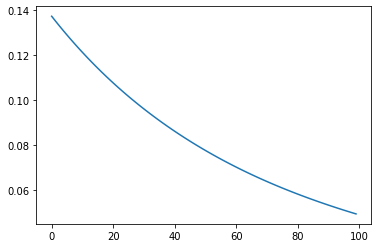

In [19]:
loss_H = [val.item() for val in loss_history]
fig, ax = plt.subplots()
ax.plot(loss_H)